# Parse Experimental Results & Generate Latex Table

In [1]:
% matplotlib inline
import os, pickle, types
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_ijcai = 'data/data-ijcai15'
data_recsys = 'data/data-recsys16'

In [3]:
dat_suffix = ['Edin', 'Glas', 'Osak', 'Toro']#, 'Melb']
dat_names = ['Edinburgh', 'Glasgow', 'Osaka', 'Toronto']#, 'Melbourne']

In [4]:
dat_types = ['all']#, 'nofew']

In [5]:
methods_all = ['Random', 'PersTour-T.5', 'PersTour-T1', 'PersTour-L.5', 'PersTour-L1', 'RankP', 'RankF', \
               'MC-DP', 'MC-ILP', 'Prop-DP', 'Prop-ILP', 'CRF']

In [6]:
num_photos = [82060, 29019, 392420, 157505]

In [7]:
#F1_rand_mean = [0.624, 0.627, 0.579, 0.613, 0.537]
#F1_rand_std  = [0.085, 0.083, 0.102, 0.093, 0.142]

In [8]:
#F1_ijcai05_mean = [0.686, 0.801, 0.656, 0.720, 0]
#F1_ijcai05_std  = [0.233, 0.214, 0.223, 0.215, 0]

In [9]:
#F1_ijcai10_mean = [0.639, 0.719, 0.611, 0.709, 0]
#F1_ijcai10_std  = [0.202, 0.211, 0.201, 0.219, 0]

In [10]:
#F1_ijcai05L_mean = [0.686, 0.660, 0.651, 0.643, 0]
#F1_ijcai05L_std  = [0.138, 0.102, 0.143, 0.114, 0]

In [11]:
#F1_ijcai10L_mean = [0.654, 0.641, 0.595, 0.611, 0]
#F1_ijcai10L_std  = [0.140, 0.114, 0.138, 0.115, 0]

### Latex Table for Dataset Statistics

In [12]:
strs = []
for dset in dat_types:
    if dset == 'all':     
        title = 'of all trajectories without loops'
        noloop = True
    if dset == 'nofew':   
        title = 'of users with more than 5 (including 5) trajectories with loops'
        noloop = False
    strs.append('\\begin{table*}\n')
    strs.append('\\centering\n')
    #strs.append('\\caption{Dataset ' + title + '}\n')
    strs.append('\\caption{Datasets description}\n')
    strs.append('\\label{table:data:' + dset + '}\n')
    #strs.append('\\small\n')
    strs.append('\\begin{tabular}{' + 'l' + 5*'r' + '} \\hline\n')
    #strs.append('\\textbf{City} & \\textbf{\\#POIs} & \\textbf{\\#Users} & ')
    #strs.append('\\textbf{\\#POI Visits} & \\textbf{\\#Trajectories} & \\textbf{\\#TotalNodes} \\\\ \\hline\n')
    strs.append('\\textbf{Dataset} & \\textbf{\\#Photos} & \\textbf{\\#POI Visits} & \\textbf{\\#Trajectories} & ')
    strs.append('\\textbf{\\#Users} \\\\ \\hline\n')
    
    for dat_ix in range(len(dat_names)):
        if noloop == True:
            ftraj = os.path.join(data_recsys, 'traj-noloop-' + dset + '-' + dat_suffix[dat_ix] + '.csv')
        else:
            ftraj = os.path.join(data_recsys, 'traj-' + dset + '-' + dat_suffix[dat_ix] + '.csv')
        traj_df = pd.read_csv(ftraj)
        total_nodes = traj_df[['trajID', 'trajLen']].copy().groupby('trajID').first().sum().values[0]
        strs.append(dat_names[dat_ix])
        #strs.append(' & ' + '{:,}'.format(traj_df['poiID'].unique().shape[0]))
        strs.append(' & ' + '{:,}'.format(num_photos[dat_ix]))
        strs.append(' & ' + '{:,}'.format(traj_df['#photo'].sum()))
        strs.append(' & ' + '{:,}'.format(traj_df['trajID'].unique().shape[0]))
        strs.append(' & ' + '{:,}'.format(traj_df['userID'].unique().shape[0]))
        #strs.append(' & ' + '{:,}'.format(total_nodes))
        strs.append(' \\\\ \n')
    strs.append('\\hline\n')
    strs.append('\\end{tabular}\n')
    strs.append('\\end{table*}\n\n')
print(''.join(strs))

\begin{table*}
\centering
\caption{Datasets description}
\label{table:data:all}
\begin{tabular}{lrrrrr} \hline
\textbf{Dataset} & \textbf{\#Photos} & \textbf{\#POI Visits} & \textbf{\#Trajectories} & \textbf{\#Users} \\ \hline
Edinburgh & 82,060 & 33,944 & 5,028 & 1,454 \\ 
Glasgow & 29,019 & 11,434 & 2,227 & 601 \\ 
Osaka & 392,420 & 7,747 & 1,115 & 450 \\ 
Toronto & 157,505 & 39,419 & 6,057 & 1,395 \\ 
\hline
\end{tabular}
\end{table*}




### Latex Table for Recommendation Results

Generate results filenames.

In [13]:
def gen_fname(dat_ix, type_ix, noloop, uspecific, alpha, C, KX):
    assert(0 <= dat_ix < len(dat_suffix))
    assert(0 <= type_ix < len(dat_types))
    assert(isinstance(noloop, bool))
    assert(isinstance(uspecific, bool))
    assert(0 < alpha < 1)
    alpha_str = str(alpha).replace('.', '_') + '-'
    C_str = 'C' + str(C) + '-'
    KX_str = str(KX) + 'X-'
    
    if noloop == True:
        loop_str = 'noloop-'
    else:
        loop_str = ''
    
    type_str = dat_types[type_ix] + '-'
    
    if uspecific == True:
        user_str = 'specific-'
        suffix = KX_str + dat_suffix[dat_ix] + '.pkl'
    else:
        user_str = 'agnostic-'
        suffix = dat_suffix[dat_ix] + '.pkl'
    
    fname = loop_str + type_str + user_str
    frank = os.path.join(data_recsys, 'rank-' + fname + suffix)
    ftran = os.path.join(data_recsys, 'tran-' + fname + suffix)
    fcomb = os.path.join(data_recsys, 'comb-' + fname + alpha_str + suffix)
    #fcrf  = os.path.join(data_recsys, 'crf-' + fname + C_str + suffix)
    fcrf1  = os.path.join(data_recsys, 'crf1-' + fname + C_str + suffix)
    frand  = os.path.join(data_recsys, 'rand-' + fname + suffix)
    fijcai = os.path.join(data_ijcai, 'ijcai-' + dat_suffix[dat_ix] + '.pkl')
    return frank, ftran, fcomb, fcrf1, frand, fijcai

In [14]:
gen_fname(1, 0, True, False, 0.5, 1, 100)

('data/data-recsys16/rank-noloop-all-agnostic-Glas.pkl',
 'data/data-recsys16/tran-noloop-all-agnostic-Glas.pkl',
 'data/data-recsys16/comb-noloop-all-agnostic-0_5-Glas.pkl',
 'data/data-recsys16/crf1-noloop-all-agnostic-C1-Glas.pkl',
 'data/data-recsys16/rand-noloop-all-agnostic-Glas.pkl',
 'data/data-ijcai15/ijcai-Glas.pkl')

Compute the F1 score for recommended trajectory.

In [15]:
def calc_F1(seq_act, seq_rec):
    '''Compute recall, precision and F1 when trajectories contain sub-tours'''
    assert(len(seq_act) > 0)
    assert(len(seq_rec) > 0)
    match_tags = np.zeros(len(seq_act), dtype=np.bool)
    for poi in seq_rec:
        for j in range(len(seq_act)):
            if match_tags[j] == False and poi == seq_act[j]:
                match_tags[j] = True
                break
    intersize = np.nonzero(match_tags)[0].shape[0]
    recall = intersize / len(seq_act)
    precision = intersize / len(seq_rec)
    F1 = 2 * precision * recall / (precision + recall)
    return F1

A simple method to evaluate POI visiting order by adapting [Kendau's tau](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient).

In [16]:
def calc_Tau(seq_act, seq_rec):
    """
    NOTE: tau-a version seems to be more reasonable for evaluating visiting order of POIs.
    An adaptation of Kendall's tau-b: https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient#Tau-b
    tau = (nc - nd - nn) / sqrt((n0 - n1)*(n0 - n2))
    where:
    nc: #concordant pairs (pair order is defined by the order of POIs in seq_act)
    nd: #discordant pairs, for POIs in seq_rec, counting only those that also in seq_act
    nn: #non-existent combination, i.e., combinations didn't appear in seq_act
    n0: n(n-1)/2, n = len(seq_act)
    n1: #ties in the first group  (i.e., seq_act), 0 here as seq_act didn't contain loops
    n2: #ties in the second group (i.e., seq_rec), only counting those appeared in seq_act
    after simplification,
    tau = (nc - nd1) / sqrt(n0*(n0 - n2))
    where nd1 = nd + nn
    """
    assert(len(seq_act) == len(seq_rec))
    assert(len(seq_act) > 0)
    assert(len(seq_act) == len(set(seq_act))) # no loops in seq_act
    n = len(seq_act)
    n0 = n*(n-1) / 2
    
    # seq_act determines the correct visiting order
    order_df = pd.DataFrame(data=np.zeros((n, n), dtype=np.bool), columns=seq_act, index=seq_act)
    for i in range(n):
        poi1 = seq_act[i]
        for j in range(i+1, n):
            poi2 = seq_act[j]
            order_df.loc[poi1, poi2] = True
            
    nc, nd1, n2 = 0, 0, 0
    for i in range(n):
        poi1 = seq_rec[i]
        for j in range(i+1, n):
            poi2 = seq_rec[j]
            if poi1 in seq_act and poi2 in seq_act:
                if poi1 != poi2:
                    if order_df.loc[poi1, poi2] == True: nc += 1
                    else: nd1 += 1
                #else: n2 += 1
            #else: nd1 += 1 # combinations didn't appear in seq_act
    #return (nc - nd1) / np.sqrt(n0*(n0 - n2))
    return (nc - nd1) / n0

Sanity check: function `calc_Tau` should give the same result as `scipy.stats.kendalltau` if the first argument is an array of number in *descending* order and all numbers in the second argument appear in the first argument.

In [17]:
from scipy.stats import kendalltau
x = [3, 2, 1]
#y = [3, 2, 1]
#y = [1, 2, 3]
y = [3, 1, 2]
#y = [1, 1, 2]
#y = [1, 2, 1]
tau = calc_Tau(x, y)
ret = kendalltau(x, y)
print(tau)
print(ret[0])

0.3333333333333333
0.333333333333


In [18]:
calc_Tau([5, 3, 9], [5, 1, 9])

0.3333333333333333

In [19]:
x = [19, 3, 5, 6]
#y = [19, 3, 5, 6]
#y = [19, 3, 1, 6]
y = [19, 1, 5, 6]
#y = [19, 3, 3, 6]
#y = [19, 5, 5, 6]
#y = [19, 19, 5, 6]
#y = [19, 3, 6, 6]
#y = [19, 6, 6, 6]
#y = [19, 1, 2, 6]
#y = [19, 5, 3, 6]
calc_Tau(x, y)

0.5

In [20]:
dict1 = pickle.load(open('data/data-ijcai15/ijcai-Edin.pkl', 'rb'))
metrics = [calc_Tau(dict1[x]['REAL'], dict1[x]['REC10L']) for x in dict1.keys()]

In [21]:
print(np.mean(metrics), np.std(metrics))

0.288790703281 0.17405226008


Load results data.

In [22]:
def load_results(dat_ix, type_ix, alpha, C, KX, uspecific):
    assert(0 <= dat_ix < len(dat_suffix))
    assert(0 <= type_ix < len(dat_types))
    assert(0 < alpha < 1)
    assert(isinstance(uspecific, bool))
    
    if uspecific == True:
        noloop = False
    else:
        noloop = True
    
    frank, ftran, fcomb, fcrf1, frand, fijcai = gen_fname(dat_ix, type_ix, noloop, uspecific, alpha, C, KX)
    #print(frank)
    assert(os.path.exists(frank))
    #print(ftran)
    assert(os.path.exists(ftran))
    #print(fcomb)
    assert(os.path.exists(fcomb))
    #print(fcrf)
    #assert(os.path.exists(fcrf))
    #print(fcrf1)
    assert(os.path.exists(fcrf1))
    #print(frand)
    assert(os.path.exists(frand))
    #print(fijcai)
    assert(os.path.exists(fijcai))


    # load results data
    recdict_rank = pickle.load(open(frank, 'rb'))
    recdict_tran = pickle.load(open(ftran, 'rb'))
    recdict_comb = pickle.load(open(fcomb, 'rb'))
    #recdict_crf  = pickle.load(open(fcrf,  'rb'))
    recdict_crf1 = pickle.load(open(fcrf1, 'rb'))
    recdict_rand = pickle.load(open(frand, 'rb'))
    recdict_ijcai = pickle.load(open(fijcai, 'rb'))
    
    return recdict_rank, recdict_tran, recdict_comb, recdict_crf1, recdict_rand, recdict_ijcai

Calculate F1-scores from loaded results.

In [23]:
def calc_metrics(recdict_rank, recdict_tran, recdict_comb, recdict_crf1, recdict_rand, recdict_ijcai, func):
    assert(isinstance(func, types.FunctionType))
    
    # deal with missing values: 
    # get rid of recommendation that not all method are successful, 
    # due to ILP timeout, <start, end> of test doesn't exist in training set,
    # and training set always constains all POIs.
    assert(np.all(sorted(recdict_rank.keys()) == sorted(recdict_tran.keys())))
    assert(np.all(sorted(recdict_rank.keys()) == sorted(recdict_comb.keys())))
    assert(np.all(sorted(recdict_ijcai.keys()) == sorted(set(recdict_ijcai.keys()) & set(recdict_rank.keys()))))
    
    keys_all = sorted(recdict_ijcai.keys() & recdict_crf1.keys())
    print(len(recdict_ijcai.keys()), len(recdict_crf1.keys()), len(keys_all))
    
    # compute F1
    rank1 = []  # rank pop
    rank2 = []  # rank feature
    #for key in sorted(recdict_rank.keys()):
    for key in keys_all:
        rank1.append(func(recdict_rank[key]['REAL'], recdict_rank[key]['REC_POP']))
        rank2.append(func(recdict_rank[key]['REAL'], recdict_rank[key]['REC_FEATURE']))
    
    tran1 = []  # transition DP
    tran2 = []  # transition ILP
    #for key in sorted(recdict_tran.keys()):
    for key in keys_all:
        tran1.append(func(recdict_tran[key]['REAL'], recdict_tran[key]['REC_DP']))
        tran2.append(func(recdict_tran[key]['REAL'], recdict_tran[key]['REC_ILP']))

    comb1 = []  # combine rank and transition DP
    comb2 = []  # combine rank and transition ILP
    #for key in sorted(recdict_comb.keys()):
    for key in keys_all:
        comb1.append(func(recdict_comb[key]['REAL'], recdict_comb[key]['REC_DP']))
        comb2.append(func(recdict_comb[key]['REAL'], recdict_comb[key]['REC_ILP']))
        
    #crf = []   # structured prediction
    #for key in sorted(recdict_crf.keys()):
    #for key in keys_all:
    #    crf.append(func(recdict_crf[key]['REAL'], recdict_crf[key]['REC_CRF']))
    
    crf1 = []   # structured prediction
    #for key in sorted(recdict_crf1.keys()):
    for key in keys_all:
        crf1.append(func(recdict_crf1[key]['REAL'], recdict_crf1[key]['REC_CRF']))
        
    rand = []   # structured prediction
    #for key in sorted(recdict_rand.keys()):
    for key in keys_all:
        rand.append(func(recdict_rand[key]['REAL'], recdict_rand[key]['REC_RAND']))
    
    ijcai05T = []   # IJCAI method
    ijcai10T = []   # IJCAI method
    ijcai05L = []   # IJCAI method
    ijcai10L = []   # IJCAI method
    #for key in sorted(recdict_ijcai.keys()):
    for key in keys_all:
        if func == calc_F1:
            ijcai05T.append(func(recdict_ijcai[key]['REAL'], recdict_ijcai[key]['REC05T']))
            ijcai10T.append(func(recdict_ijcai[key]['REAL'], recdict_ijcai[key]['REC10T']))
        ijcai05L.append(func(recdict_ijcai[key]['REAL'], recdict_ijcai[key]['REC05L']))
        ijcai10L.append(func(recdict_ijcai[key]['REAL'], recdict_ijcai[key]['REC10L']))        
    
    # compute mean and std of F1
    metrics = [rand]
    if func == calc_F1:
        metrics = metrics + [ijcai05T, ijcai10T]
    metrics = metrics + [ijcai05L, ijcai10L, rank1, rank2, tran1, tran2, comb1, comb2, crf1]
    means = [np.mean(x) for x in metrics]
    stds  = [np.std(x)  for x in metrics]
    
    return means, stds

Generate Latex tables from calculated metrics.

In [24]:
def gen_latex_table(mean_df, std_df, ismax_df, type_ix, uspecific, title):
    assert(isinstance(uspecific, bool))
    if dat_types[type_ix] == 'all': 
        dstr = 'of all trajectories without loops'
        ustr = 'user agnostic setting'
    if dat_types[type_ix] == 'nofew': 
        dstr = 'of users with more than 5 (including 5) trajectories with loops'
        ustr = 'user specific setting'

    strs = []
    strs.append('\\begin{table*}\n')
    strs.append('\\centering\n')
    #strs.append('\\caption{Experimental Results: ' + ustr + ' ' + dstr + '}\n')
    strs.append('\\caption{' + title + '}\n')
    #strs.append('\\small\n')
    strs.append('\\begin{tabular}{l|' + (mean_df.shape[1])*'c' + '} \\hline\n')
    for col in mean_df.columns:
        strs.append(' & ' + col)
    strs.append(' \\\\ \\hline\n')
    for ix in mean_df.index:
        for j in range(mean_df.shape[1]):
            if j == 0: strs.append(ix + ' ')
            jx = mean_df.columns[j]
            strs.append('& $')
            if ismax_df.loc[ix, jx] == True: strs.append('\\mathbf{')
            strs.append('%.3f' % mean_df.loc[ix, jx] + '\\pm' + '%.3f' % std_df.loc[ix, jx])
            if ismax_df.loc[ix, jx] == True: strs.append('}')
            strs.append('$ ')
        strs.append('\\\\\n')
    strs.append('\\hline\n')
    strs.append('\\end{tabular}\n')
    strs.append('\\end{table*}\n')
    return ''.join(strs)

Generate evaluation data tables.

In [25]:
KX = 100  # 100 folds in user specific setting
alpha = 0.5
C = 1

In [26]:
func = calc_F1
#func = calc_Tau

In [27]:
if func == calc_Tau: 
    methods = [methods_all[0]] + methods_all[3:]
else:
    methods = methods_all.copy()
    

for type_ix in range(len(dat_types)):
    mean_df = pd.DataFrame(data=np.zeros((len(methods), len(dat_names)), dtype=np.float), \
                           columns=dat_names, index=methods)
    std_df  = pd.DataFrame(data=np.zeros((len(methods), len(dat_names)), dtype=np.float), \
                           columns=dat_names, index=methods)
    
    if dat_types[type_ix] == 'all':
        uspecific = False
    if dat_types[type_ix] == 'nofew':
        uspecific = True
        
    for dat_ix in range(len(dat_suffix)):
        recdict_rank, recdict_tran, recdict_comb, recdict_crf1, recdict_rand, recdict_ijcai = load_results\
        (dat_ix, type_ix, alpha, C, KX, uspecific)
        means, stds = calc_metrics(recdict_rank, recdict_tran, recdict_comb, recdict_crf1, \
                                   recdict_rand, recdict_ijcai, func)
        #print(len(means), len(stds), len(methods))
        assert(len(means) == len(stds) == len(methods))
        mean_df[dat_names[dat_ix]] = means
        std_df[dat_names[dat_ix]]  = stds
        
    ismax_df  = pd.DataFrame(data=np.zeros(mean_df.shape, dtype=np.bool), \
                             columns=mean_df.columns, index=mean_df.index)
    for col in ismax_df.columns:
        maxix = mean_df[col].argmax()
        ismax_df.loc[maxix, col] = True
    
    if func == calc_F1:
        title = 'Performance comparison on four datasets in terms of trajectory F$_1$-score'
    else:
        title = 'Performance comparison on four datasets in terms of $\\tau$'
    strs = gen_latex_table(mean_df, std_df, ismax_df, type_ix, uspecific, title)
    
    print(strs)

628 634 628
111 109 109
47 41 41
335 333 333
\begin{table*}
\centering
\caption{Performance comparison on four datasets in terms of trajectory F$_1$-score}
\begin{tabular}{l|cccc} \hline
 & Edinburgh & Glasgow & Osaka & Toronto \\ \hline
Random & $0.571\pm0.139$ & $0.632\pm0.124$ & $0.628\pm0.114$ & $0.621\pm0.128$ \\
PersTour-T.5 & $0.657\pm0.222$ & $0.804\pm0.214$ & $0.709\pm0.224$ & $0.720\pm0.215$ \\
PersTour-T1 & $0.611\pm0.201$ & $0.723\pm0.209$ & $0.642\pm0.186$ & $0.710\pm0.219$ \\
PersTour-L.5 & $0.651\pm0.143$ & $0.662\pm0.102$ & $0.699\pm0.139$ & $0.642\pm0.112$ \\
PersTour-L1 & $0.596\pm0.138$ & $0.642\pm0.113$ & $0.657\pm0.142$ & $0.612\pm0.114$ \\
RankP & $0.701\pm0.160$ & $0.746\pm0.167$ & $0.666\pm0.130$ & $0.679\pm0.120$ \\
RankF & $0.694\pm0.155$ & $0.777\pm0.170$ & $0.690\pm0.108$ & $0.753\pm0.167$ \\
MC-DP & $0.629\pm0.171$ & $0.721\pm0.164$ & $0.690\pm0.160$ & $0.662\pm0.156$ \\
MC-ILP & $0.678\pm0.149$ & $0.738\pm0.169$ & $0.720\pm0.148$ & $0.688\pm0.139$ \\
Prop-

## Comparsion between CRF and other Methods

109


634
109
41
333


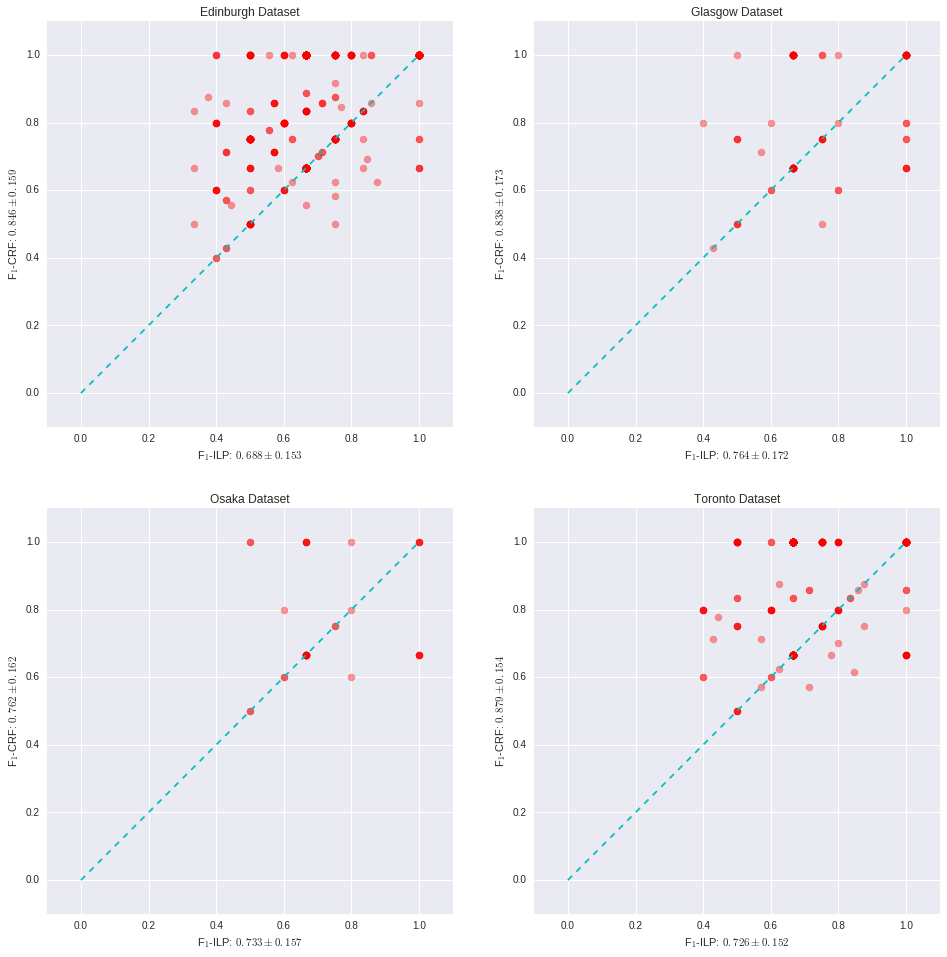

In [54]:
plt.figure(figsize=[16, 16])
for dat_ix in range(len(dat_names)):
    frank, ftran, fcomb, fcrf1, frand, fijcai = gen_fname(dat_ix, 0, True, False, alpha, C, KX) # Glasgow
    recdict_comb = pickle.load(open(fcomb, 'rb'))
    recdict_crf1 = pickle.load(open(fcrf1, 'rb'))
    common_keys = sorted(set(recdict_comb.keys()) & set(recdict_crf1.keys()))
    print(len(common_keys))
    F1_comb = [calc_F1(recdict_comb[x]['REAL'], recdict_comb[x]['REC_ILP']) for x in common_keys]
    F1_crf1 = [calc_F1(recdict_crf1[x]['REAL'], recdict_crf1[x]['REC_CRF']) for x in common_keys]

    plt.subplot(2, 2, dat_ix+1)
    plt.scatter(F1_comb, F1_crf1, alpha=0.4, color='r', s=50)
    plt.plot([0, 1], [0, 1], ls='--', color='c')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel(''.join(['F$_1$-ILP: $', str(np.round(np.mean(F1_comb),3)), '\pm', str(np.round(np.std(F1_comb),3)), '$']))
    plt.ylabel(''.join(['F$_1$-CRF: $', str(np.round(np.mean(F1_crf1),3)), '\pm', str(np.round(np.std(F1_crf1),3)), '$']))
    plt.title(dat_names[dat_ix] + ' Dataset')

### Hyperparameters Tuning Results

NOTE: **POI popularity** used here is defined as *the number of distinct users* that visited the POI, which is not affected by user specific upsampling of trajectories.

In [ ]:
dstype = dat_types[2]
dat_ix = 1

In [ ]:
KXs = [1, 2, 4, 8, 10, 20, 50, 100]
ALPHAs = [.1, .2, .3, .4, .5, .6, .7, .8, .9]

Methods based on ranking and transition matrix.

In [ ]:
methods_F1mean = np.zeros((4, len(KXs)), dtype=np.float)
methods_F1std = np.zeros((4, len(KXs)), dtype=np.float)
alphastr = str(0.5).replace('.', '_') + '-'
for j in range(len(KXs)):
    kx = KXs[j]
    kxstr = str(kx) + 'X-'
    recdict_rank, recdict_tran, recdict_comb = load_results(dstype, dat_ix, kxstr, alphastr, uspecific=True)
    F1mean, F1std = calc_metrics(recdict_rank, recdict_tran, recdict_comb)
    for method_ix in [0, 1, 2, 3]:
        methods_F1mean[method_ix, j] = F1mean[method_ix]
        methods_F1std[method_ix, j] = F1std[method_ix]

plt.figure(figsize=[8, 6])
plt.suptitle('Dataset: %s' % datnames[dat_ix], y=0.95, fontsize=12)
for k in [0, 1, 2, 3]:
    ax = plt.subplot(2, 2, k+1)
    plt.errorbar(KXs, methods_F1mean[k], yerr=methods_F1std[k])
    maxix = np.argmax(methods_F1mean[k])
    plt.plot(KXs[maxix], methods_F1mean[k, maxix], marker='o', markersize=10, markerfacecolor='m', markeredgewidth=0)
    plt.xlim([0.9, 109])
    plt.ylim([0, 1.0])
    plt.title('%s, Best_F1: %.3f' % (methods[k], methods_F1mean[k, maxix]), y=0.1)
    plt.xscale('log')
    if k > 1: plt.xlabel('Folds')
    if k % 2 == 0: plt.ylabel('F1')

Methods combine ranking with transition matrix.

In [ ]:
for method_ix in [4, 5]:
    method_F1mean = np.zeros((len(ALPHAs), len(KXs)), dtype=np.float)
    method_F1std = np.zeros((len(ALPHAs), len(KXs)), dtype=np.float)
    for i in range(len(ALPHAs)):
        alpha = ALPHAs[i]
        alphastr = str(alpha).replace('.', '_') + '-'
        for j in range(len(KXs)):
            kx = KXs[j]
            kxstr = str(kx) + 'X-'
            recdict_rank, recdict_tran, recdict_comb = load_results(dstype, dat_ix, kxstr, alphastr, uspecific=True)
            F1mean, F1std = calc_metrics(recdict_rank, recdict_tran, recdict_comb)
            method_F1mean[i, j] = F1mean[method_ix]
            method_F1std[i, j] = F1std[method_ix]

    plt.figure(figsize=[12, 9])
    plt.suptitle('Dataset: %s, Method: %s' % (datnames[dat_ix], methods[method_ix]), y=0.95, fontsize=12)
    for k in range(len(ALPHAs)):
        ax = plt.subplot(3, 3, k+1)
        plt.errorbar(KXs, method_F1mean[k], yerr=method_F1std[k])
        maxix = np.argmax(method_F1mean[k])
        plt.plot(KXs[maxix], method_F1mean[k, maxix], marker='o', markersize=10, markerfacecolor='m', markeredgewidth=0)
        plt.xlim([0.9, 109])
        plt.ylim([0, 1.0])
        plt.title('$\\alpha$ = %.1f, Best_F1: %.3f' % (ALPHAs[k], method_F1mean[k, maxix]), y=0.1)
        plt.xscale('log')
        if k > 5: plt.xlabel('Folds')
        if k % 3 == 0: plt.ylabel('F1')